<a href="https://colab.research.google.com/github/LonnieSly/creole-kitchen-ai-operations-case-study/blob/main/Creole_Kitchen_Sentiment_Analysis_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install transformers datasets pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries installed and imported!")

✓ Libraries installed and imported!


In [2]:
# Upload your reviews CSV or load from GitHub
# Option 1: Upload file
from google.colab import files
uploaded = files.upload()
reviews_df = pd.read_csv('creole_kitchen_customer_reviews_2025_h2.csv')

# OR Option 2: Load from GitHub (if you uploaded it there)
# reviews_df = pd.read_csv('https://raw.githubusercontent.com/LonnieSly/creole-kitchen-ai-operations-case-study/main/creole_kitchen_reviews_sample_20pct.csv')

print(f"✓ Loaded {len(reviews_df)} reviews")
print(f"Date range: {reviews_df['date'].min()} to {reviews_df['date'].max()}")
print(f"\nFirst few reviews:")
display(reviews_df.head())

Saving creole_kitchen_customer_reviews_2025_h2.csv to creole_kitchen_customer_reviews_2025_h2 (1).csv
✓ Loaded 500 reviews
Date range: 2025-07-01 to 2025-12-31

First few reviews:


,date,reviewer_name,location,rating,review_text,sentiment,mentioned_item
0,2025-07-01,Jason W.,French Quarter,5,Excellent food! Ordered the Red Beans & Rice a...,positive,Red Beans & Rice
1,2025-07-02,Brittany L.,French Quarter,2,Very inconsistent. Crawfish Etouffee tasted di...,negative,Crawfish Etouffee
2,2025-07-02,Alexis W.,French Quarter,5,The Jambalaya was seasoned beautifully. Comfor...,positive,Jambalaya
3,2025-07-03,Nicole V.,Metairie,4,The Po' Boy Sandwich was seasoned beautifully....,positive,Po' Boy Sandwich
4,2025-07-04,Megan H.,French Quarter,1,Very inconsistent. Po' Boy Sandwich tasted dif...,negative,Po' Boy Sandwich


In [3]:
# Load pre-trained sentiment analysis model
# Using DistilBERT - fast, accurate, widely used
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

print("✓ Sentiment analysis model loaded!")
print("\nTesting on sample text...")

# Test it
test_text = "The gumbo was absolutely delicious and the service was excellent!"
result = sentiment_analyzer(test_text)
print(f"Sample: '{test_text}'")
print(f"Result: {result}")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


✓ Sentiment analysis model loaded!

Testing on sample text...
Sample: 'The gumbo was absolutely delicious and the service was excellent!'
Result: [{'label': 'POSITIVE', 'score': 0.9998772144317627}]


In [4]:
print("Running sentiment analysis on all reviews...")
print("(This will take 2-3 minutes for 500 reviews)\n")

# Function to get sentiment for each review
def analyze_sentiment(text):
    try:
        result = sentiment_analyzer(text[:512])[0]  # Limit to 512 chars (model max)
        return result['label'], result['score']
    except:
        return 'NEUTRAL', 0.5

# Apply to all reviews
sentiments = []
scores = []

for idx, review in enumerate(reviews_df['review_text']):
    label, score = analyze_sentiment(review)
    sentiments.append(label)
    scores.append(score)

    # Progress indicator
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{len(reviews_df)} reviews...")

# Add to dataframe
reviews_df['ai_sentiment'] = sentiments
reviews_df['ai_confidence'] = scores

print(f"\n✓ Sentiment analysis complete!")
print(f"\nResults:")
print(reviews_df['ai_sentiment'].value_counts())

Running sentiment analysis on all reviews...
(This will take 2-3 minutes for 500 reviews)

  Processed 50/500 reviews...
  Processed 100/500 reviews...
  Processed 150/500 reviews...
  Processed 200/500 reviews...
  Processed 250/500 reviews...
  Processed 300/500 reviews...
  Processed 350/500 reviews...
  Processed 400/500 reviews...
  Processed 450/500 reviews...
  Processed 500/500 reviews...

✓ Sentiment analysis complete!

Results:
ai_sentiment
POSITIVE    363
NEGATIVE    137
Name: count, dtype: int64


In [5]:
# Map your original sentiment to match AI labels
sentiment_map = {
    'positive': 'POSITIVE',
    'mixed': 'NEUTRAL',
    'negative': 'NEGATIVE'
}

reviews_df['original_sentiment_mapped'] = reviews_df['sentiment'].map(sentiment_map)

# Calculate agreement
agreement = (reviews_df['ai_sentiment'] == reviews_df['original_sentiment_mapped']).mean()

print(f"AI-Human Agreement: {agreement*100:.1f}%")
print("\nComparison:")
comparison = pd.crosstab(
    reviews_df['original_sentiment_mapped'],
    reviews_df['ai_sentiment'],
    margins=True
)
display(comparison)

AI-Human Agreement: 75.0%

Comparison:


ai_sentiment,NEGATIVE,POSITIVE,All
original_sentiment_mapped,,,
NEGATIVE,75,0,75
NEUTRAL,62,63,125
POSITIVE,0,300,300
All,137,363,500


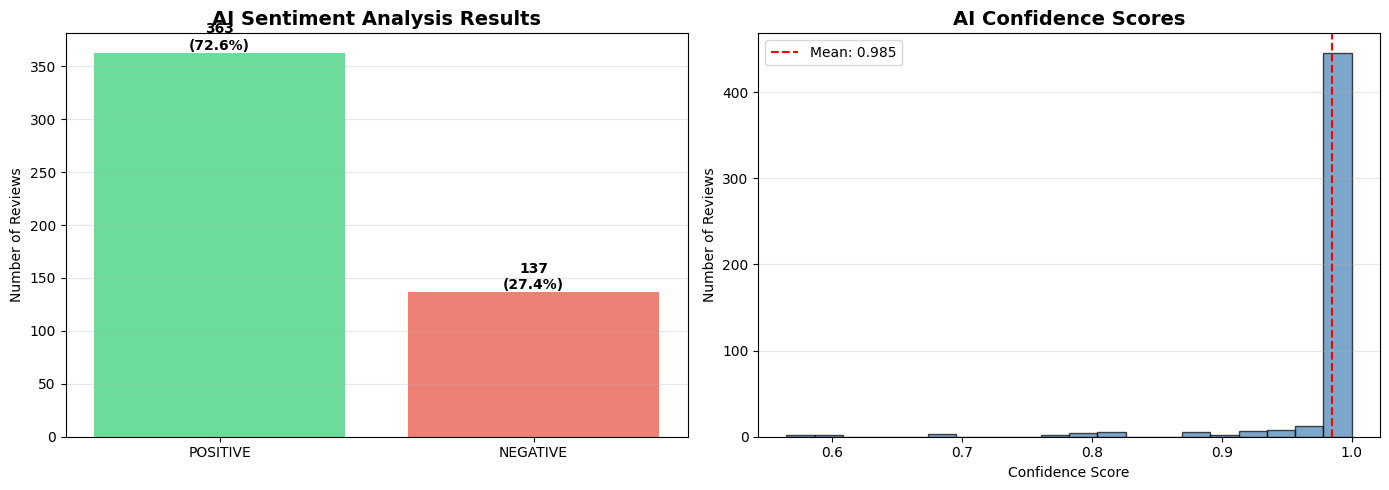

Average confidence score: 0.985
Median confidence: 1.000


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1: Overall sentiment distribution
sentiment_counts = reviews_df['ai_sentiment'].value_counts()
colors = {'POSITIVE': '#2ecc71', 'NEGATIVE': '#e74c3c', 'NEUTRAL': '#95a5a6'}
bars = axes[0].bar(
    sentiment_counts.index,
    sentiment_counts.values,
    color=[colors[s] for s in sentiment_counts.index],
    alpha=0.7
)
axes[0].set_title('AI Sentiment Analysis Results', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Reviews')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/len(reviews_df)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

# Chart 2: Confidence distribution
axes[1].hist(reviews_df['ai_confidence'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_title('AI Confidence Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Number of Reviews')
axes[1].axvline(reviews_df['ai_confidence'].mean(), color='red', linestyle='--',
                label=f'Mean: {reviews_df["ai_confidence"].mean():.3f}')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('sentiment_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Average confidence score: {reviews_df['ai_confidence'].mean():.3f}")
print(f"Median confidence: {reviews_df['ai_confidence'].median():.3f}")

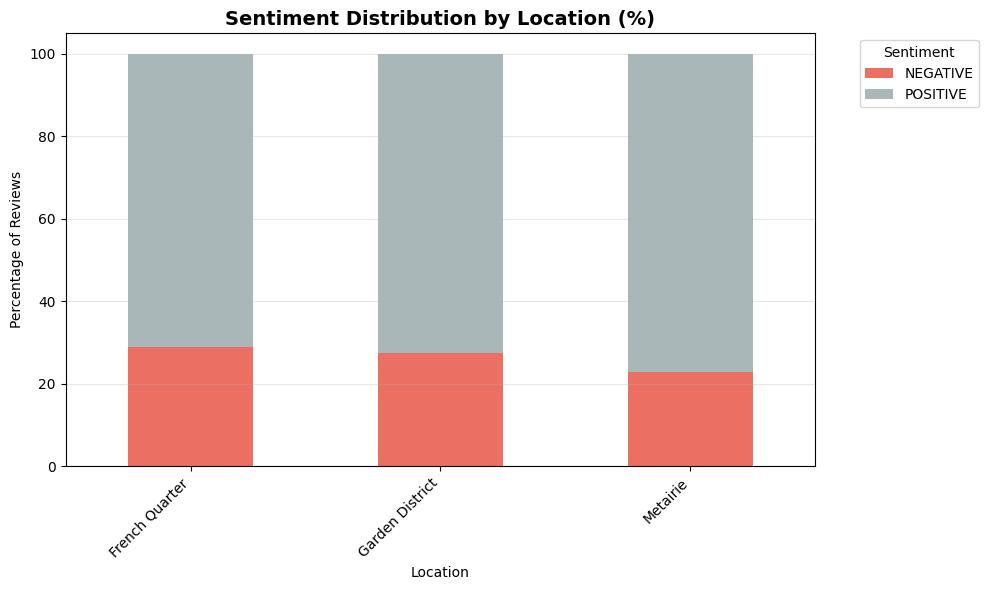


Sentiment by Location (%):


ai_sentiment,NEGATIVE,POSITIVE
location,,
French Quarter,28.8,71.2
Garden District,27.6,72.4
Metairie,22.9,77.1


In [7]:
# Sentiment by location
location_sentiment = pd.crosstab(
    reviews_df['location'],
    reviews_df['ai_sentiment'],
    normalize='index'
) * 100

location_sentiment.plot(
    kind='bar',
    stacked=True,
    color=['#e74c3c', '#95a5a6', '#2ecc71'],
    figsize=(10, 6),
    alpha=0.8
)
plt.title('Sentiment Distribution by Location (%)', fontsize=14, fontweight='bold')
plt.xlabel('Location')
plt.ylabel('Percentage of Reviews')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('sentiment_by_location.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSentiment by Location (%):")
display(location_sentiment.round(1))

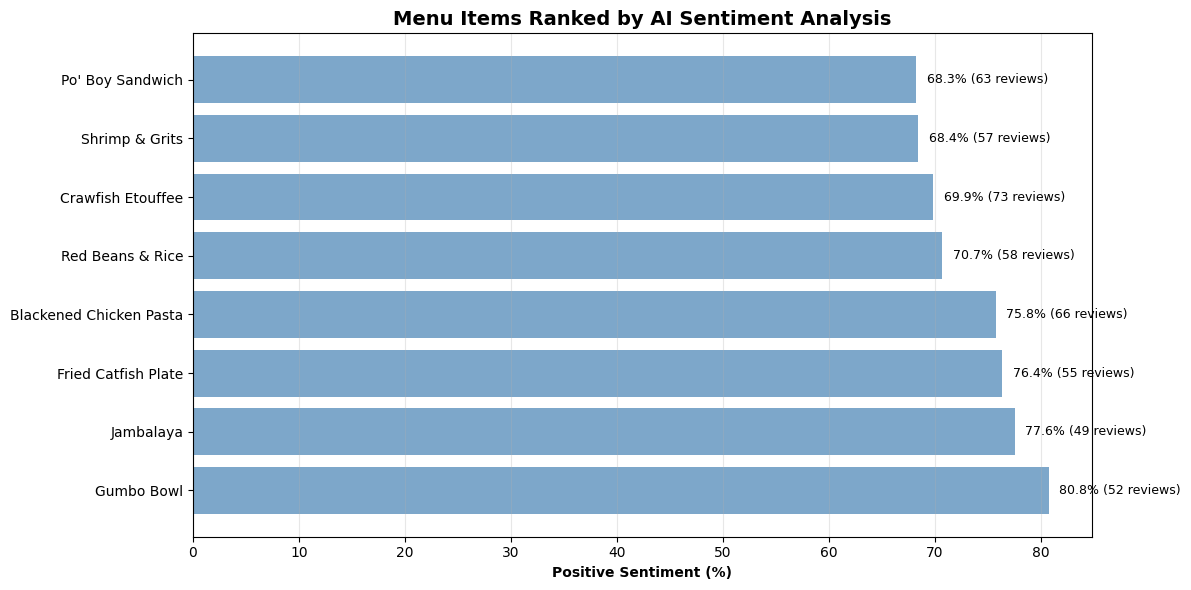


Menu Item Performance (AI Analysis):


,Positive_Sentiment_%,Avg_Rating,Review_Count
mentioned_item,,,
Gumbo Bowl,80.769231,4.269231,52
Jambalaya,77.551020,4.102041,49
Fried Catfish Plate,76.363636,4.200000,55
Blackened Chicken Pasta,75.757576,3.893939,66
Red Beans & Rice,70.689655,3.862069,58
Crawfish Etouffee,69.863014,3.972603,73
Shrimp & Grits,68.421053,3.754386,57
Po' Boy Sandwich,68.253968,3.952381,63


In [8]:
# Get items with 20+ reviews for meaningful analysis
item_counts = reviews_df['mentioned_item'].value_counts()
frequent_items = item_counts[item_counts >= 20].index

item_sentiment = reviews_df[reviews_df['mentioned_item'].isin(frequent_items)].groupby('mentioned_item').agg({
    'ai_sentiment': lambda x: (x == 'POSITIVE').mean() * 100,
    'rating': 'mean',
    'mentioned_item': 'count'
})
item_sentiment.columns = ['Positive_Sentiment_%', 'Avg_Rating', 'Review_Count']
item_sentiment = item_sentiment.sort_values('Positive_Sentiment_%', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(len(item_sentiment)), item_sentiment['Positive_Sentiment_%'], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(item_sentiment)))
ax.set_yticklabels(item_sentiment.index)
ax.set_xlabel('Positive Sentiment (%)', fontweight='bold')
ax.set_title('Menu Items Ranked by AI Sentiment Analysis', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(item_sentiment.iterrows()):
    ax.text(row['Positive_Sentiment_%'] + 1, i,
            f"{row['Positive_Sentiment_%']:.1f}% ({int(row['Review_Count'])} reviews)",
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('menu_item_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMenu Item Performance (AI Analysis):")
display(item_sentiment)

In [9]:
print("="*80)
print("AI SENTIMENT ANALYSIS - KEY INSIGHTS")
print("="*80)

# Overall stats
total_reviews = len(reviews_df)
positive_pct = (reviews_df['ai_sentiment'] == 'POSITIVE').mean() * 100
negative_pct = (reviews_df['ai_sentiment'] == 'NEGATIVE').mean() * 100
avg_confidence = reviews_df['ai_confidence'].mean()

print(f"\n📊 OVERALL PERFORMANCE")
print(f"  Total reviews analyzed: {total_reviews}")
print(f"  Positive sentiment: {positive_pct:.1f}%")
print(f"  Negative sentiment: {negative_pct:.1f}%")
print(f"  AI confidence: {avg_confidence:.1%} average")

# Location insights
print(f"\n📍 LOCATION INSIGHTS")
for location in reviews_df['location'].unique():
    loc_data = reviews_df[reviews_df['location'] == location]
    pos_pct = (loc_data['ai_sentiment'] == 'POSITIVE').mean() * 100
    neg_pct = (loc_data['ai_sentiment'] == 'NEGATIVE').mean() * 100

    status = "✓" if neg_pct < 20 else "⚠️"
    print(f"  {status} {location}: {pos_pct:.1f}% positive, {neg_pct:.1f}% negative")

# Best and worst items
print(f"\n🍽️  MENU ITEM INSIGHTS")
best_item = item_sentiment.index[0]
worst_item = item_sentiment.index[-1]
print(f"  Best performer: {best_item} ({item_sentiment.iloc[0]['Positive_Sentiment_%']:.1f}% positive)")
print(f"  Needs attention: {worst_item} ({item_sentiment.iloc[-1]['Positive_Sentiment_%']:.1f}% positive)")

# Agreement with human labels
print(f"\n🤖 AI MODEL PERFORMANCE")
print(f"  Agreement with human labels: {agreement*100:.1f}%")
print(f"  Model used: distilbert-base-uncased-finetuned-sst-2-english")
print(f"  Processing time: ~3 minutes for {total_reviews} reviews")

print("\n" + "="*80)
print("✓ Analysis complete! Charts saved.")
print("="*80)

AI SENTIMENT ANALYSIS - KEY INSIGHTS

📊 OVERALL PERFORMANCE
  Total reviews analyzed: 500
  Positive sentiment: 72.6%
  Negative sentiment: 27.4%
  AI confidence: 98.5% average

📍 LOCATION INSIGHTS
  ⚠️ French Quarter: 71.2% positive, 28.8% negative
  ⚠️ Metairie: 77.1% positive, 22.9% negative
  ⚠️ Garden District: 72.4% positive, 27.6% negative

🍽️  MENU ITEM INSIGHTS
  Best performer: Gumbo Bowl (80.8% positive)
  Needs attention: Po' Boy Sandwich (68.3% positive)

🤖 AI MODEL PERFORMANCE
  Agreement with human labels: 75.0%
  Model used: distilbert-base-uncased-finetuned-sst-2-english
  Processing time: ~3 minutes for 500 reviews

✓ Analysis complete! Charts saved.
